In [1]:
copick_config = """{
    "config_type": "cryoet_data_portal",
    "name": "polnet",
    "description": "A Data Portal project.",
    "version": "1.0.0",

    "pickable_objects": [
        {
            "name": "membrane",
            "is_particle": false,
            "label": 1,
            "go_id": "GO:0016020",            
            "color": [150,150, 150, 255],
            "radius": 10
        },
        {
            "name": "adp-mitochondrial",
            "is_particle": true,
            "pdb_id": "6MRD",
            "go_id": "GO:1990220",
            "label": 2,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "alkaline-phosphate",
            "is_particle": true,
            "pdb_id": "1ZEF",
            "go_id": "UniProtKB:P05187",
            "label": 3,
            "color": [  0, 117, 220, 255],
            "radius": 75,
            "map_threshold": 0.037
        },
        {
            "name": "nucleosome",
            "is_particle": true,
            "pdb_id": "6UPH",
            "go_id": "GO:0000786",
            "label": 4,
            "color": [  0, 117, 220, 255],
            "radius": 65,
            "map_threshold": 0.037
        },        
        {
            "name": "ribosome",
            "is_particle": true,
            "pdb_id": "7TM3",
            "go_id": "GO:0022626",
            "label": 5,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "vault",
            "is_particle": true,
            "pdb_id": "7PKZ",
            "go_id": "UniProtKB:Q62667",
            "label": 6,
            "color": [  0, 117, 220, 255],
            "radius": 165,
            "map_threshold": 0.037
        },
        {
            "name": "virus-like-capsid",
            "is_particle": true,
            "pdb_id": "6NK5",
            "go_id": "GO:0170047",
            "label": 7,
            "color": [  0, 117, 220, 255],
            "radius": 140,
            "map_threshold": 0.037
        }             
    ],

    "overlay_root": "local:///tmp/CZDP_10439/overlay/",

    "overlay_fs_args": {
        "auto_mkdir": true
    },

    "dataset_ids": [10439]
}
"""
# TODO set overlay root to a place safe in kaggle notebooks

config_file = "synthetic_data.json"

with open(config_file, "w") as f:
    f.write(copick_config)

In [2]:
import copick
import copick_utils

# config_file = "/Users/kharrington/Data/copick/synthetic_data_10439.json"

root = copick.from_file(config_file)

run_name = "16193"
example_run = root.get_run(run_name)
voxel_spacing= 10
tomo_type = "wbp"
paint_scale = 0.75
painting_segmentation_name = "paintedPicks"

In [3]:
# Convert picks into segmentations
import re
from copick_utils.segmentation.segmentation_from_picks import segmentation_from_picks

for pickable_object in root.pickable_objects:
    if pickable_object.is_particle:
        print(f"Painting {pickable_object}")
        # radius = pickable_object.radius / voxel_spacing * paint_scale
        radius = 10
        object_name = pickable_object.name
        pick_set = example_run.get_picks(object_name=object_name)[0]
        segmentation_from_picks(radius, painting_segmentation_name, example_run, voxel_spacing, tomo_type, pickable_object, pick_set, user_id="paintedPicks", session_id="0")


Painting CopickObject(name=adp-mitochondrial, is_particle=True, label=2, color=(0, 117, 220, 255), emdb_id=None, pdb_id=6MRD, identifier=GO:1990220 threshold=0.037) at 0x107397f70
Painting CopickObject(name=alkaline-phosphate, is_particle=True, label=3, color=(0, 117, 220, 255), emdb_id=None, pdb_id=1ZEF, identifier=UniProtKB:P05187 threshold=0.037) at 0x17b4b67d0
Painting CopickObject(name=nucleosome, is_particle=True, label=4, color=(0, 117, 220, 255), emdb_id=None, pdb_id=6UPH, identifier=GO:0000786 threshold=0.037) at 0x17b4b6830
Painting CopickObject(name=ribosome, is_particle=True, label=5, color=(0, 117, 220, 255), emdb_id=None, pdb_id=7TM3, identifier=GO:0022626 threshold=0.037) at 0x17b4b6950
Painting CopickObject(name=vault, is_particle=True, label=6, color=(0, 117, 220, 255), emdb_id=None, pdb_id=7PKZ, identifier=UniProtKB:Q62667 threshold=0.037) at 0x17b4b5360
Painting CopickObject(name=virus-like-capsid, is_particle=True, label=7, color=(0, 117, 220, 255), emdb_id=None, pd

In [4]:
# napari visualization

import napari
import numpy as np
import zarr
from copick_torch import data, transforms
from morphospaces.datasets.utils import PatchManager
from torch.utils.data import ConcatDataset

voxel_spacing_obj = example_run.get_voxel_spacing(voxel_spacing)
tomogram = voxel_spacing_obj.tomograms[0]
image = zarr.open(tomogram.zarr(), mode='r')['0']
tomogram_data = image[:]

# Get the segmentation mask
seg = example_run.get_segmentations(is_multilabel=True, name=painting_segmentation_name, voxel_size=voxel_spacing)
if len(seg) == 0:
    raise ValueError(f"No segmentations found for session '{session_id}' and segmentation type '{segmentation_type}'.")
segmentation = zarr.open(seg[0].zarr().path, mode="r")['0']
segmentation_data = segmentation[:]

# Create a Napari viewer
viewer = napari.Viewer()

# Display the tomogram data
viewer.add_image(np.asarray(tomogram_data), name='Tomogram')

# Display the segmentation mask
viewer.add_labels(np.asarray(segmentation_data), name='Segmentation Mask', opacity=0.5)

# Create a labels array to show the patches
labels = np.zeros_like(tomogram_data, dtype=np.int32)

user_id = "paintedPicks"
session_id = "0"

image_key = "zarr_tomogram"
labels_key = "zarr_mask"
patch_shape = (96, 96, 96)
# patch_stride = (24, 24, 24)
# patch_stride = (8, 8, 8)
patch_stride = (48, 48, 48)
patch_threshold = 0.9

ds, unique_label_values = data.load_dataset(
    config_file, run_name, tomo_type, user_id, session_id, painting_segmentation_name, voxel_spacing, None, patch_shape, patch_stride, labels_key, patch_threshold
)

# Check if ds is a ConcatDataset
if isinstance(ds, ConcatDataset):
    patches = []
    for dataset in ds.datasets:
        if hasattr(dataset, 'patches'):
            patches.extend(dataset.patches.slices)
        else:
            print(f"Dataset {type(dataset)} does not have 'patches' attribute")
else:
    patches = ds.patches.slices

# Label the patches
patch_id = 1
for patch in patches:
    if len(patch) == 3:
        z_start, y_start, x_start = patch[0].start, patch[1].start, patch[2].start
        z_end, y_end, x_end = patch[0].stop, patch[1].stop, patch[2].stop
        labels[z_start:z_end, y_start:y_end, x_start:x_end] = patch_id
        patch_id += 1
    else:
        print(f"Unexpected patch format: {patch}")

# Add the labels layer to highlight patches in 3D
viewer.add_labels(labels, name='Patch Labels')

viewer.layers[0].bounding_box.visible = True

# Start the Napari event loop
napari.run()


/Users/adityarao/Library/Caches/pypoetry/virtualenvs/cz-cryoet-preprocessing-Mgfti45s-py3.10/lib/python3.10/site-packages/dask/array/core.py:1721: FutureWarning: The `numpy.copy` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


In [5]:
seg_data = np.asarray(segmentation_data)
print(f"labels: {np.unique(seg_data)}")

viewer = napari.Viewer()

labels: [0 7]


In [6]:
viewer.add_image(seg_data>0)

<Image layer 'Image' at 0x30d850790>

In [7]:
napari.run()

/Users/adityarao/Library/Caches/pypoetry/virtualenvs/cz-cryoet-preprocessing-Mgfti45s-py3.10/lib/python3.10/site-packages/dask/array/core.py:1721: FutureWarning: The `numpy.copy` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  warnings.warn(


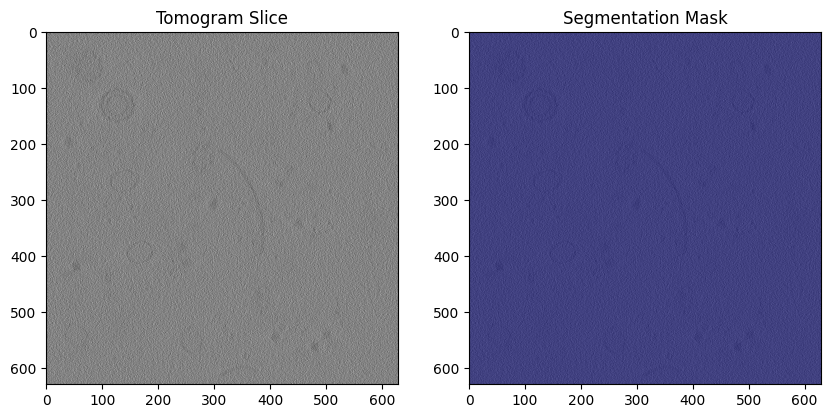

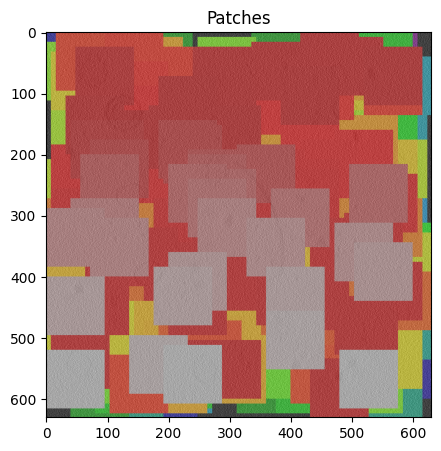

In [8]:
# matplotlib visualization

import numpy as np
import matplotlib.pyplot as plt
import zarr
from copick_torch import data, transforms
from morphospaces.datasets.utils import PatchManager
from torch.utils.data import ConcatDataset

# Load the tomogram and segmentation data
voxel_spacing_obj = example_run.get_voxel_spacing(voxel_spacing)
tomogram = voxel_spacing_obj.tomograms[0]
image = zarr.open(tomogram.zarr(), mode='r')['0']
tomogram_data = image[:]

# Get the segmentation mask
seg = example_run.get_segmentations(is_multilabel=True, name=painting_segmentation_name, voxel_size=voxel_spacing)
if len(seg) == 0:
    raise ValueError(f"No segmentations found for session '{session_id}' and segmentation type '{segmentation_type}'.")
segmentation = zarr.open(seg[0].zarr().path, mode="r")['0']
segmentation_data = segmentation[:]

# Create a labels array to show the patches
labels = np.zeros_like(tomogram_data, dtype=np.int32)

user_id = "paintedPicks"
session_id = "0"
image_key = "zarr_tomogram"
labels_key = "zarr_mask"
patch_shape = (96, 96, 96)
patch_stride = (8, 8, 8)
patch_threshold = 0.05

# Load the dataset
ds, unique_label_values = data.load_dataset(
    config_file, run_name, tomo_type, user_id, session_id, painting_segmentation_name, voxel_spacing, None, patch_shape, patch_stride, labels_key, patch_threshold
)

# Check if ds is a ConcatDataset
if isinstance(ds, ConcatDataset):
    patches = []
    for dataset in ds.datasets:
        if hasattr(dataset, 'patches'):
            patches.extend(dataset.patches.slices)
        else:
            print(f"Dataset {type(dataset)} does not have 'patches' attribute")
else:
    patches = ds.patches.slices

# Label the patches
patch_id = 1
for patch in patches:
    if len(patch) == 3:
        z_start, y_start, x_start = patch[0].start, patch[1].start, patch[2].start
        z_end, y_end, x_end = patch[0].stop, patch[1].stop, patch[2].stop
        labels[z_start:z_end, y_start:y_end, x_start:x_end] = patch_id
        patch_id += 1
    else:
        print(f"Unexpected patch format: {patch}")

# Choose a slice to display (e.g., middle slice in z-axis)
slice_index = tomogram_data.shape[0] // 2

# Plot the tomogram slice
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(tomogram_data[slice_index], cmap='gray')
plt.title('Tomogram Slice')

# Plot the segmentation mask overlay
plt.subplot(1, 2, 2)
plt.imshow(tomogram_data[slice_index], cmap='gray')
plt.imshow(segmentation_data[slice_index], cmap='jet', alpha=0.5)
plt.title('Segmentation Mask')

plt.show()

# Plot the patches (just showing patches on a 2D slice for illustration)
plt.figure(figsize=(5, 5))
plt.imshow(tomogram_data[slice_index], cmap='gray')
plt.imshow(labels[slice_index], cmap='nipy_spectral', alpha=0.5)
plt.title('Patches')
plt.show()
